In [3]:
%matplotlib inline

In [4]:
#!conda install scikit-image -y

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

import numpy as np
import os
import pandas as pd
from skimage import io, transform

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [12]:
### Loading FER data ###
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"
device = torch.device(dev)
# if torch.cuda.is_available:
#     print("CUDA is available.... 1 2 3...")

In [13]:
df_train = pd.read_csv("./FER-2013/train.csv")
df = pd.read_csv("./FER-2013/fer2013/fer2013.csv")
df_train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [14]:
df['pixelss']=[[int(y) for y in x.split()] for x in df['pixels']]

In [15]:
df.head()

,emotion,pixels,Usage,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [16]:
df_train=df[df['Usage']=='Training']
df_valid=df[df['Usage']=='PrivateTest']
df_test=df[df['Usage']=='PublicTest']

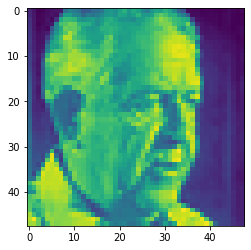

In [17]:
im=np.array(df['pixelss'][6969])
img=im.reshape(48,48)
plt.imshow(img, interpolation='nearest')
plt.show()

In [18]:
part={}
part['train']= list(range(0,len(df_train)))
part['valid']= list(range(0,len(df_valid)))
part['test']= list(range(0,len(df_test)))
train_labels=df_train['emotion'].tolist()
valid_labels=df_valid['emotion'].tolist()
test_labels=df_test['emotion'].tolist()

In [19]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixelss']
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion']

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

In [20]:
params = {'batch_size': 64,'shuffle': True,'num_workers': 10}

In [22]:
from torch.utils import data
import pandas as pd
import albumentations
from albumentations import pytorch as AT
from tqdm import tqdm
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
#from torchsummary import summary
from collections import OrderedDict
import torch.optim as optim

class AlbumentationWrapper(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()
    ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([
                                             
            #albumentations.Resize(48,48),
    albumentations.HorizontalFlip(),
    albumentations.Cutout(2,2,2,0.5),
    albumentations.GaussNoise(),
    #albumentations.ElasticTransform(),    
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()    
    ])
            
    def __call__(self,img):
        #img = np.array(img)
        img = self.aug(image=img)['image']
        return img

In [23]:
train_transforms , validation_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('test')

In [24]:
training_set = Dataset(df_train, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(df_valid, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(df_test, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

In [25]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

In [26]:
def train(model, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  running_loss = 0.0
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
    train_acc.append(100*correct/processed)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')

In [27]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

In [28]:
 class Net(nn.Module):
        
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)            
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)            
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(8 * 8 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        #####################################################


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 8 * 8 * 32)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x


    def forward(self, x):
        x = self.stn(x)            # transform the input
        x = self.convblock1(x)     # Perform the usual forward pass
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

  0%|          | 0/449 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.020000000000000004 


Loss=1.5240991115570068 Batch_id=448 le=0.01893656628692835 Accuracy=26.97: 100%|██████████| 449/449 [00:42<00:00, 10.67it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 1350/3589 (37.61%)

EPOCH: 1 LR: 0.01893656628692835 


Loss=1.6406059265136719 Batch_id=448 le=0.015997574317068365 Accuracy=36.16: 100%|██████████| 449/449 [00:41<00:00, 10.73it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 1708/3589 (47.59%)

EPOCH: 2 LR: 0.015997574317068365 


Loss=1.5101609230041504 Batch_id=448 le=0.011877562566685818 Accuracy=39.42: 100%|██████████| 449/449 [00:41<00:00, 10.70it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 1901/3589 (52.97%)

EPOCH: 3 LR: 0.011877562566685818 


Loss=1.6088314056396484 Batch_id=448 le=0.0075501664565825145 Accuracy=40.52: 100%|██████████| 449/449 [00:41<00:00, 10.71it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 2024/3589 (56.39%)

EPOCH: 4 LR: 0.0075501664565825145 


Loss=1.5247586965560913 Batch_id=448 le=0.004038030189713788 Accuracy=42.28: 100%|██████████| 449/449 [00:42<00:00, 10.63it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 2159/3589 (60.16%)

EPOCH: 5 LR: 0.004038030189713788 


Loss=1.3432718515396118 Batch_id=448 le=0.0021711369018773768 Accuracy=43.31: 100%|██████████| 449/449 [00:42<00:00, 10.68it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 2155/3589 (60.04%)

EPOCH: 6 LR: 0.0021711369018773768 


Loss=1.391136646270752 Batch_id=448 le=0.001997273042813163 Accuracy=44.14: 100%|██████████| 449/449 [00:41<00:00, 10.73it/s]  
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 2226/3589 (62.02%)

EPOCH: 7 LR: 0.001997273042813163 


Loss=1.2796413898468018 Batch_id=448 le=0.0019807511907248246 Accuracy=44.70: 100%|██████████| 449/449 [00:42<00:00, 10.67it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0160, Accuracy: 2227/3589 (62.05%)

EPOCH: 8 LR: 0.0019807511907248246 


Loss=1.2694411277770996 Batch_id=448 le=0.0019494929687730493 Accuracy=45.24: 100%|██████████| 449/449 [00:42<00:00, 10.49it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 2189/3589 (60.99%)

EPOCH: 9 LR: 0.0019494929687730493 


Loss=1.4014192819595337 Batch_id=448 le=0.0019039685297112243 Accuracy=45.31: 100%|██████████| 449/449 [00:42<00:00, 10.61it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 2211/3589 (61.60%)

EPOCH: 10 LR: 0.0019039685297112243 


Loss=1.5115668773651123 Batch_id=448 le=0.0018448626034771058 Accuracy=45.90: 100%|██████████| 449/449 [00:41<00:00, 10.71it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 2234/3589 (62.25%)

EPOCH: 11 LR: 0.0018448626034771058 


Loss=1.471215009689331 Batch_id=448 le=0.001773064198217203 Accuracy=46.77: 100%|██████████| 449/449 [00:41<00:00, 10.71it/s]  
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 2272/3589 (63.30%)

EPOCH: 12 LR: 0.001773064198217203 


Loss=1.4983160495758057 Batch_id=448 le=0.0016896532287767657 Accuracy=46.93: 100%|██████████| 449/449 [00:42<00:00, 10.64it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2273/3589 (63.33%)

EPOCH: 13 LR: 0.0016896532287767657 


Loss=1.3192341327667236 Batch_id=448 le=0.0015958842737753241 Accuracy=47.39: 100%|██████████| 449/449 [00:42<00:00, 10.66it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 2268/3589 (63.19%)

EPOCH: 14 LR: 0.0015958842737753241 


Loss=1.4579006433486938 Batch_id=448 le=0.0014931677055764845 Accuracy=48.40: 100%|██████████| 449/449 [00:42<00:00, 10.68it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 2251/3589 (62.72%)

EPOCH: 15 LR: 0.0014931677055764845 


Loss=1.1855028867721558 Batch_id=448 le=0.0013830484769748045 Accuracy=48.94: 100%|██████████| 449/449 [00:42<00:00, 10.64it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 2245/3589 (62.55%)

EPOCH: 16 LR: 0.0013830484769748045 


Loss=1.1319756507873535 Batch_id=448 le=0.0012671828836677153 Accuracy=49.68: 100%|██████████| 449/449 [00:41<00:00, 10.72it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 2261/3589 (63.00%)

EPOCH: 17 LR: 0.0012671828836677153 


Loss=0.9511611461639404 Batch_id=448 le=0.001147313652026549 Accuracy=50.19: 100%|██████████| 449/449 [00:42<00:00, 10.63it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2301/3589 (64.11%)

EPOCH: 18 LR: 0.001147313652026549 


Loss=0.9432078003883362 Batch_id=448 le=0.0010252437268697782 Accuracy=51.28: 100%|██████████| 449/449 [00:42<00:00, 10.68it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2294/3589 (63.92%)

EPOCH: 19 LR: 0.0010252437268697782 


Loss=1.2184226512908936 Batch_id=448 le=0.0009028091534947628 Accuracy=51.81: 100%|██████████| 449/449 [00:42<00:00, 10.64it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 2299/3589 (64.06%)

EPOCH: 20 LR: 0.0009028091534947628 


Loss=1.175162672996521 Batch_id=448 le=0.0007818514618474794 Accuracy=52.53: 100%|██████████| 449/449 [00:42<00:00, 10.67it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 2316/3589 (64.53%)

EPOCH: 21 LR: 0.0007818514618474794 


Loss=1.3866852521896362 Batch_id=448 le=0.0006641899681980345 Accuracy=53.50: 100%|██████████| 449/449 [00:41<00:00, 10.71it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 2321/3589 (64.67%)

EPOCH: 22 LR: 0.0006641899681980345 


Loss=1.1260106563568115 Batch_id=448 le=0.0005515944109305376 Accuracy=54.01: 100%|██████████| 449/449 [00:42<00:00, 10.65it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 2311/3589 (64.39%)

EPOCH: 23 LR: 0.0005515944109305376 


Loss=1.064319133758545 Batch_id=448 le=0.00044575833203052746 Accuracy=54.87: 100%|██████████| 449/449 [00:42<00:00, 10.69it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2319/3589 (64.61%)

EPOCH: 24 LR: 0.00044575833203052746 


Loss=1.2020471096038818 Batch_id=448 le=0.0003482736046371552 Accuracy=55.80: 100%|██████████| 449/449 [00:41<00:00, 10.70it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 2330/3589 (64.92%)

EPOCH: 25 LR: 0.0003482736046371552 


Loss=1.1608355045318604 Batch_id=448 le=0.00026060648978945284 Accuracy=55.78: 100%|██████████| 449/449 [00:42<00:00, 10.64it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 2331/3589 (64.95%)

EPOCH: 26 LR: 0.00026060648978945284 


Loss=1.1431193351745605 Batch_id=448 le=0.00018407558249550676 Accuracy=55.86: 100%|██████████| 449/449 [00:42<00:00, 10.66it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2340/3589 (65.20%)

EPOCH: 27 LR: 0.00018407558249550676 


Loss=0.9752162098884583 Batch_id=448 le=0.00011983197883618375 Accuracy=56.19: 100%|██████████| 449/449 [00:42<00:00, 10.67it/s]
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 2335/3589 (65.06%)

EPOCH: 28 LR: 0.00011983197883618375 


Loss=1.0880647897720337 Batch_id=448 le=6.884196240863205e-05 Accuracy=56.76: 100%|██████████| 449/449 [00:42<00:00, 10.64it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 2344/3589 (65.31%)

EPOCH: 29 LR: 6.884196240863205e-05 


Loss=1.089098572731018 Batch_id=448 le=3.187247052156096e-05 Accuracy=56.36: 100%|██████████| 449/449 [00:42<00:00, 10.66it/s]  
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 2332/3589 (64.98%)

EPOCH: 30 LR: 3.187247052156096e-05 


Loss=1.1169662475585938 Batch_id=448 le=9.479558744250297e-06 Accuracy=56.65: 100%|██████████| 449/449 [00:42<00:00, 10.65it/s] 
  0%|          | 0/449 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 2337/3589 (65.12%)

EPOCH: 31 LR: 9.479558744250297e-06 


Loss=1.152350664138794 Batch_id=448 le=2.00003731321086e-06 Accuracy=57.29: 100%|██████████| 449/449 [00:42<00:00, 10.62it/s]   



Test set: Average loss: 0.0159, Accuracy: 2342/3589 (65.25%)



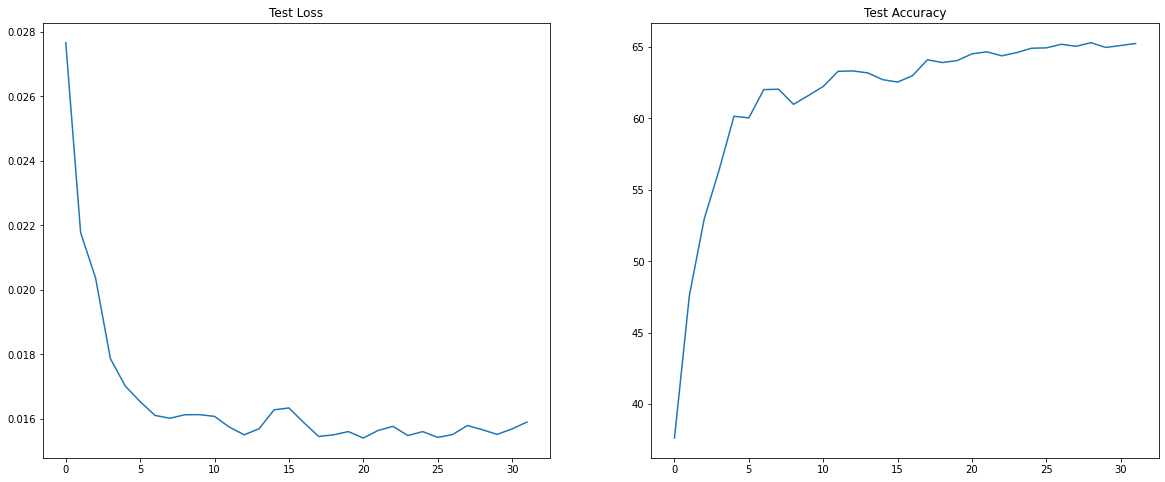

In [40]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

model=Net(1)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.0002, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=0.1, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

In [43]:
torch.save(model.state_dict(), 'model.pth')

In [33]:
class FerDataset(Dataset):
    """FER dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.frame.iloc[idx, 0].astype('str'))
        image = io.imread(img_name)
        landmarks = self.frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'emotion': emotion, 'pixels': pixels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
df = pd.read_csv("./FER-2013/train.csv")
df.head(n=4)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...


In [37]:
face_dataset = FerDataset(csv_file='./FER-2013/train.csv',
                                    root_dir='.')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

#     print(i, sample['emotion'].shape, sample['pixels'].shape)

#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
#     show_landmarks(**sample)

#     if i == 3:
#         plt.show()
#         break

FileNotFoundError: No such file: '/home/naruto/Desktop/AI/STN/0'

<Figure size 432x288 with 0 Axes>

In [4]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

0it [00:00, ?it/s]

KeyboardInterrupt: 

Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:: /_static/img/stn/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        #self.fc2 = nn.
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [45]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(training_generator):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(training_generator.dataset),
                100. * batch_idx / len(training_generator), loss.item()))
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in validation_generator:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_generator.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(validation_generator.dataset),
                      100. * correct / len(validation_generator.dataset)))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



In [46]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

RuntimeError: Given groups=1, weight of size [8, 1, 7, 7], expected input[64, 3, 48, 48] to have 1 channels, but got 3 channels instead